# Hierarchical models

## Theory: what is a hierarchical model?

In general: a model with hyperparameters, i.e. parameters that
probabilistically control other parameters.

E.g.

In this model $\tau$ is a hyperparameter. Is $\mu$ a hyperparameter???

Hierarchical models are great for describing the situation where you
know some measurements have something in common (e.g. they come from the
same group), but you don’t know how much.

[Learn
more!](https://betanalpha.github.io/assets/case_studies/hierarchical_modeling.html)

## Example: always be closing!

Plushycorp employs 10 salespeople who go door to door selling cute
plushies. The number of plushies that each salesperson sold every
working day for two weeks was recorded. What can Plushycorp find out
from this data?

To answer the question in a best-case scenario, we can use a
hierarchical model to run a “digital twin” of this experiment with known
parameters and data generating process. Specifically, we can assume that
the number $y_{ij}$ of plushies that salesperson $i$ sells on day $j$
depends on a combination of factors:

-   The baseline amount $\mu$ that a totally average salesperson would
    sell on a normal day
-   The salesperson’s ability $ability_i$
-   An effect $day\ effect_j$ for the day of the week: people are
    thought to buy fewer and fewer plushies as the week drags on.
-   Some random variation

A good first step for modelling count data is the Poisson distribution,
so let’s assume that the sales measurements follow the following Poisson
distribution:[1]

We know that the salespeople have different abilities, but how just
different are they? Since this isn’t really clear to Plushycorp, it
makes sense to introduce a parameter $\tau_{ability}$ into the model:

Now we have a hierarchical model!

We can make a similar argument for the day of the week effects:[2]

Finally we can complete our model by specifying prior distributions for
the non-hierarchical parameters:[3]

To test out our model with fake data, we can use Python to generate a
fake set of salespeople and days, then generate some sales consistently
with our model. Next we can generate some data,

[1] Note the use of the log link function.

[2] Can you think of a better model for day effects given the
information above??

[3] $HN$ here refers to the “half-normal” distribution, a decent default
prior for hierarchical standard deviations

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd

N_SALESPERSON = 10
N_WEEK = 2
DAY_NAMES = ["Mon", "Tue", "Wed", "Thu", "Fri"]
BASELINE = 2  # 2 plushies in one day is fine
TAU_ABILITY = 0.35
TAU_DAY = 0.2

SEED = 12345
DATA_DIR = Path("../data")

rng = np.random.default_rng(seed=SEED)

with open(DATA_DIR / "names.json", "r") as f:
    name_directory = json.load(f)

names = [
    f"{first_name} {surname}"
    for first_name, surname in zip(
        *map(
            lambda l: rng.choice(l, size=N_SALESPERSON, replace=False),
            name_directory.values()
        )
    )
]

abilities = rng.normal(loc=0, scale=TAU_ABILITY, size=N_SALESPERSON)

salespeople = pd.DataFrame({"salesperson": names, "ability": abilities})

salespeople

In [2]:
day_effects = sorted(
    rng.normal(loc=0, scale=TAU_DAY, size=len(DAY_NAMES))
)[::-1]  # This (i.e. `[::-1]`) is a nice way to reverse a list
days = pd.DataFrame({"day": DAY_NAMES, "day_effect": day_effects})
days

In [3]:
sales = (
    days
    .merge(salespeople, how="cross")
    .merge(pd.DataFrame({"week":[1, 2, 3, 4]}), how="cross")
    .assign(
        sales=lambda df: rng.poisson(
            np.exp(np.log(BASELINE) + df["ability"] + df["day_effect"])
        )
    )
    [["week", "day", "salesperson", "day_effect", "ability", "sales"]]
    .copy()
)
sales.head()

Here is the fortnightly sales chart

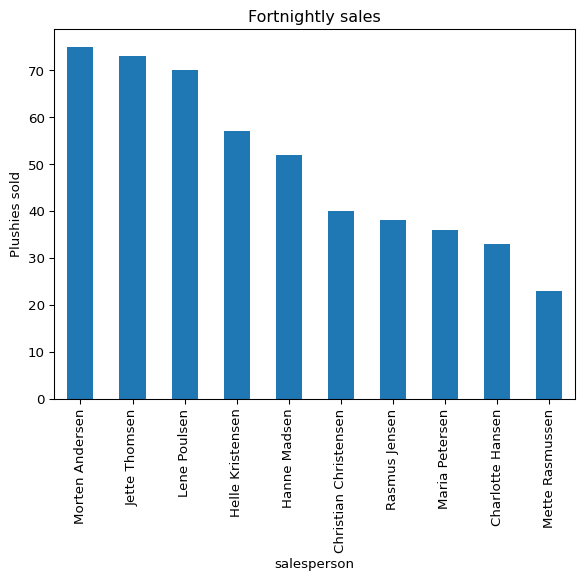

In [4]:
total_sales = (
    sales.groupby("salesperson")["sales"].sum().sort_values(ascending=False)
)

total_sales.plot(kind="bar", ylabel="Plushies sold", title="Fortnightly sales")

It’s pretty straightforward to represent hierarchical models with Stan,
almost like Stan was designed for it!

In [5]:
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file="../src/stan/plushies.stan")
print(model.code())

data {
 int<lower=1> N;
 int<lower=1> N_salesperson;
 int<lower=1> N_day;
 array[N] int<lower=1,upper=N_salesperson> salesperson;
 array[N] int<lower=1,upper=N_day> day;
 array[N] int<lower=0> sales;
 int<lower=0,upper=1> likelihood;
}
parameters {
 real log_mu;
 vector[N_salesperson] ability;
 vector[N_day] day_effect;
 real<lower=0> tau_ability;
 real<lower=0> tau_day;
}
transformed parameters {
 vector[N] log_lambda = log_mu + ability[salesperson] + day_effect[day]; 
}
model {
  log_mu ~ normal(0, 1);
  ability ~ normal(0, tau_ability);
  day_effect ~ normal(0, tau_day);
  tau_ability ~ normal(0, 0.5);
  tau_day ~ normal(0, 0.5);
  if (likelihood){
    sales ~ poisson_log(log_lambda);
  }
}
generated quantities {
 real mu = exp(log_mu);
 vector[N] lambda = exp(log_lambda);
 array[N] int yrep = poisson_rng(lambda);
 vector[N] llik; 
 for (n in 1:N){
   llik[n] = poisson_lpmf(sales[n] | lambda[n]);
 }
}



In [6]:
import arviz as az
from stanio.json import process_dictionary

def one_encode(l):
    """One-encode a 1d list-like thing."""
    return dict(zip(l, range(1, len(l) + 1)))


salesperson_codes = one_encode(salespeople["salesperson"])
day_codes = one_encode(days["day"])
data_prior = process_dictionary({
        "N": len(sales),
        "N_salesperson": len(salespeople),
        "N_day": len(days),
        "salesperson": sales["salesperson"].map(salesperson_codes),
        "day": sales["day"].map(day_codes),
        "sales": sales["sales"],
        "likelihood": 0
    }
)
data_posterior = data_prior | {"likelihood": 1}
mcmc_prior = model.sample(data=data_prior)
mcmc_posterior = model.sample(data=data_posterior)
idata = az.from_cmdstanpy(
    posterior=mcmc_posterior,
    prior=mcmc_prior,
    log_likelihood="llik",
    posterior_predictive="yrep",
    observed_data=data_posterior,
    coords={
        "salesperson": salespeople["salesperson"],
        "day": days["day"],
        "observation": sales.index
    },
    dims={
        "lambda": ["observation"],
        "ability": ["salesperson"],
        "day_effect": ["day"],
        "llik": ["observation"],
        "yrep": ["observation"]
    }
)
idata

17:21:30 - cmdstanpy - INFO - CmdStan start processing
17:21:30 - cmdstanpy - INFO - CmdStan done processing.
17:21:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
    Chain 1 had 10 divergent transitions (1.0%)
    Chain 2 had 2 divergent transitions (0.2%)
    Chain 3 had 10 divergent transitions (1.0%)
    Chain 4 had 6 divergent transitions (0.6%)
    Use the "diagnose()" method on the CmdStanMCMC object to see further information.
17:21:30 - cmdstanpy - INFO - CmdStan start processing
17:21:31 - cmdstanpy - INFO - CmdStan done processing.
17:21:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'plushies.stan', line 22, column 2 to column 35)
Consider re-running with show_console=True if the above output is unclear!

arviz.InferenceData 
 
 
 
 
 
 posterior 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.Dataset> Size: 13MB
Dimensions: (chain: 4, draw: 1000, salesperson: 10, day: 5,
 log_lambda_dim_0: 200, observation: 200)
Coordinates:
 * chain (chain) int64 32B 0 1 2 3
 * draw (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
 * salesperson (salesperson) object 80B 'Morten Andersen' ... 'Jette T...
 * day (day) object 40B 'Mon' 'Tue' 'Wed' 'Thu' 'Fri'
 * log_lambda_dim_0 (log_lambda_dim_0) int64 2kB 0 1 2 3 4 ... 196 197 198 199
 * observation (observation) int64 2kB 0 1 2 3 4 ... 195 196 197 198 199
Data variables:
 log_mu (chain, draw) float64 32kB 0.5986 0.5269 ... 0.5878 0.5619
 ability (chain, draw, salesperson) float64 320kB 0.6552 ... 0.5479
 day_effect (chain, draw, day) float64 160kB 0.4152 ... -0.05532
 tau_ability (chain, draw) float64 32kB 0.4402 0.3831 ... 0.4605 0.3561
 tau_day (chain, draw) float64 32kB 0.3285 0.4587 ... 0.2063 0.2787
 log_lambda (chain, draw, log_lambda_dim_0) float64 6MB 1.669 ... 1...
 mu (chain, draw) float64 32kB 1.82 1.694 1.735 ... 1.8 1.754
 lambda (chain, draw, observation) float64 6MB 5.307 ... 2.871
Attributes:
 created_at: 2024-05-03T15:21:31.843026
 arviz_version: 0.17.1
 inference_library: cmdstanpy
 inference_library_version: 1.2.1 xarray.Dataset Dimensions: chain : 4 draw : 1000 salesperson : 10 day : 5 log_lambda_dim_0 : 200 observation : 200 Coordinates: (6) chain (chain) int64 0 1 2 3 array([0, 1, 2, 3]) draw (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999 array([ 0, 1, 2, ..., 997, 998, 999]) salesperson (salesperson) object 'Morten Andersen' ... 'Jette Tho... array(['Morten Andersen', 'Lene Poulsen', 'Rasmus Jensen', 'Hanne Madsen',
 'Mette Rasmussen', 'Christian Christensen', 'Helle Kristensen',
 'Charlotte Hansen', 'Maria Petersen', 'Jette Thomsen'], dtype=object) day (day) object 'Mon' 'Tue' 'Wed' 'Thu' 'Fri' array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], dtype=object) log_lambda_dim_0 (log_lambda_dim_0) int64 0 1 2 3 4 5 ... 195 196 197 198 199 array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
 196, 197, 198, 199]) observation (observation) int64 0 1 2 3 4 5 ... 195 196 197 198 199 array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
 196, 197, 198, 199]) Data variables: (8) log_mu (chain, draw) float64 0.5986 0.5269 ... 0.5878 0.

In [7]:
az.summary(idata, var_names="~lambda", filter_vars="regex")

## The problem with hierarchical models: funnels

Did you notice that cmdstanpy printed some divergent transition warnings
above? This illustrates a pervasive problem with hierarchical models:
funnel-shaped marginal posterior distributions. The plot below shows the
values of the parameter $\tau_{day}$ and the corresponding day effect
values for Monday in the prior samples:

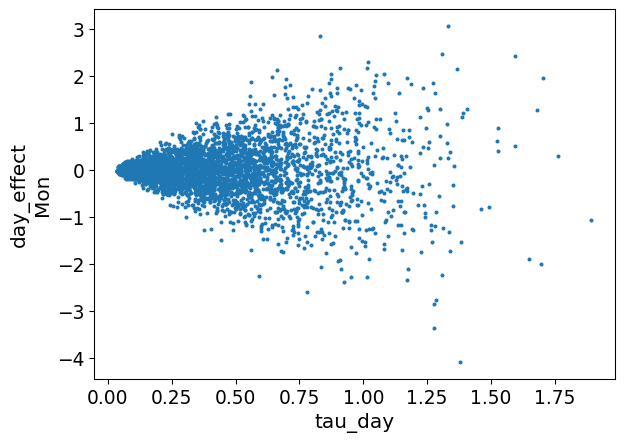

In [8]:
az.plot_pair(
    idata.prior,
    var_names=["tau_day", "day_effect"],
    coords={"day": ["Mon"]},
);

As we discussed previously, funnels are hard to sample because of their
inconsistent characteristic lengths. Unfortunately, they are often
inevitable in hierarchical models. Do you get an idea why from the
graph?

There are three main solutions to funnels: add more information, tune
the HMC algorithm or reparameterise the model.

### Add more information

The posterior distribution didn’t have any divergent transitions. This
is probably because the extra information in the measurements made it
easier to sample. Comparing the marginal distributions from above
illustrates how this can happen: note that the difference in scale
between the neck and the bowl of the funnel is less extreme for the
posterior samples.

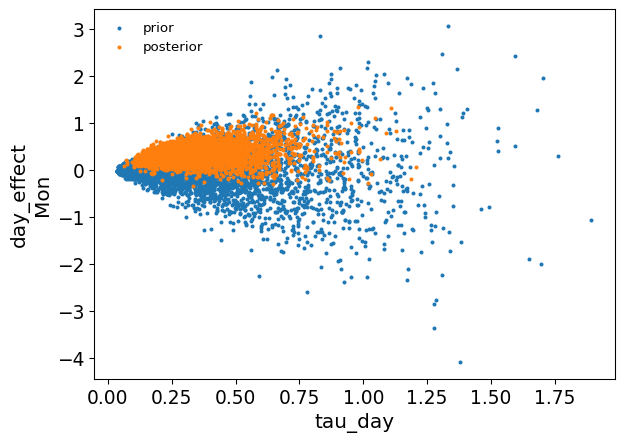

In [9]:
from matplotlib import pyplot as plt
f, ax = plt.subplots()
az.plot_pair(
    idata.prior,
    var_names=["tau_day", "day_effect"],
    coords={"day": ["Mon"]},
    ax=ax,
    scatter_kwargs={"label": "prior"},
);
az.plot_pair(
    idata.posterior,
    var_names=["tau_day", "day_effect"],
    coords={"day": ["Mon"]},
    ax=ax,
    scatter_kwargs={"label": "posterior"},
);
ax.legend(frameon=False);

If better measurements aren’t available, divergences can often be
avoided by searching for extra information that can justify narrower
priors.

### Tune the algorithm

Stan allows increasing the length of the warmup phase (`iter_warmup`,
default 2000), bringing the target acceptance probability close to 1
(`adapt_delta`, default 0.8) and by increasing the leapfrog integrator’s
maximum tree depth (`max_treedepth`, default 10). All of these changes
trade speed for reliability.

In [10]:
mcmc_prior_2 = model.sample(
    data=data_prior,
    iter_warmup=3000,
    adapt_delta=0.99,
    max_treedepth=12
)

17:21:32 - cmdstanpy - INFO - CmdStan start processing
17:21:35 - cmdstanpy - INFO - CmdStan done processing.
17:21:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
    Chain 1 had 1 divergent transitions (0.1%)
    Chain 3 had 1 divergent transitions (0.1%)
    Chain 4 had 3 divergent transitions (0.3%)
    Use the "diagnose()" method on the CmdStanMCMC object to see further information.

Unfortunately even quite aggressive tuning doesn’t get rid of all the
divergent transitions in this case.

### Reparameterise

The idea with reparameterisation is to define auxiliary parameters which
don’t have problematic relationships, then recover the problematic
parameters later.

“Non-centred” parameterisations take a distribution with the form
$\alpha\sim
D(\mu,\sigma)$ and express it as follows:

In [11]:
model_nc = CmdStanModel(stan_file="../src/stan/plushies-nc.stan")
print(model_nc.code())

data {
 int<lower=1> N;
 int<lower=1> N_salesperson;
 int<lower=1> N_day;
 array[N] int<lower=1,upper=N_salesperson> salesperson;
 array[N] int<lower=1,upper=N_day> day;
 array[N] int<lower=0> sales;
 int<lower=0,upper=1> likelihood;
}
parameters {
 real log_mu;
 vector[N_salesperson] ability_z;
 vector[N_day] day_effect_z;
 real<lower=0> tau_ability;
 real<lower=0> tau_day;
}
transformed parameters {
 vector[N_salesperson] ability = ability_z * tau_ability;
 vector[N_day] day_effect = day_effect_z * tau_day;
 vector[N] log_lambda = log_mu + ability[salesperson] + day_effect[day]; 
}
model {
  log_mu ~ normal(0, 1);
  ability_z ~ normal(0, 1);
  day_effect_z ~ normal(0, 1);
  tau_ability ~ normal(0, 1);
  tau_day ~ normal(0, 1);
  if (likelihood){
    sales ~ poisson_log(log_lambda);
  }
}
generated quantities {
 real mu = exp(log_mu);
 vector[N] lambda = exp(log_lambda);
 array[N] int yrep = poisson_rng(lambda);
 vector[N] llik; 
 for (n in 1:N){
   llik[n] = poisson_lpmf(sales[n] | l

In [12]:
mcmc_prior_nc = model.sample(
    data=data_prior,
    iter_warmup=3000,
    adapt_delta=0.999,
    max_treedepth=12
)

17:21:36 - cmdstanpy - INFO - CmdStan start processing
17:21:57 - cmdstanpy - INFO - CmdStan done processing.
17:21:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'plushies.stan', line 23, column 2 to column 34)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'plushies.stan', line 22, column 2 to column 35)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'plushies.stan', line 23, column 2 to column 34)
Consider re-running with show_console=True if the above output is unclear!
17:21:57 - cmdstanpy - WARNING - Some chains may have failed to converge.
    Chain 1 had 12 divergent transitions (1.2%)
    Chain 3 had 1 divergent transitions (0.1%)
    Use the "diagnose()" method on the CmdStanMCMC object to see further information.

Beware of using non-centred parameterisation as a default: it isn’t
guaranteed to be better.

## So how many plushies do I need to sell?

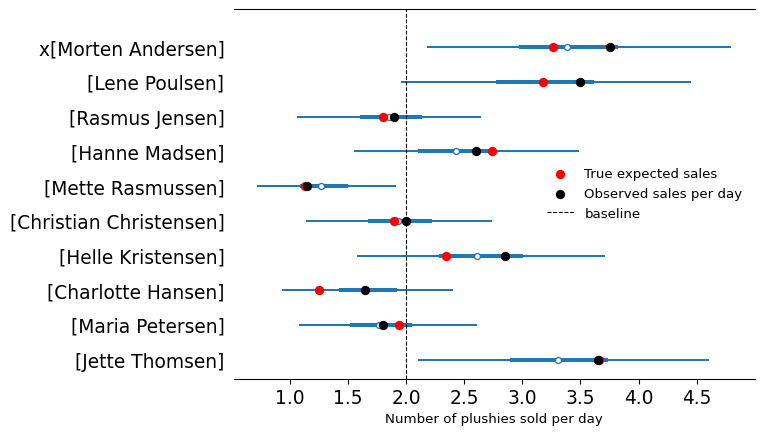

In [13]:
f, ax = plt.subplots()
az.plot_forest(
    np.exp(idata.posterior["log_mu"] + idata.posterior["ability"]),
    kind="forestplot",
    combined=True,
    ax=ax,
    show=False,
);
ax.scatter(
    np.exp(np.log(BASELINE) + salespeople["ability"]), 
    ax.get_yticks()[::-1], 
    color="red", 
    label="True expected sales",
    zorder=2
)
ax.scatter(
    sales.groupby("salesperson")["sales"].mean().reindex(salespeople["salesperson"]), 
    ax.get_yticks()[::-1], 
    color="black", 
    label="Observed sales per day",
    zorder=3
)
ax.set(title="", xlabel="Number of plushies sold per day")
ax.axvline(BASELINE, linestyle="--", label="baseline", linewidth=0.8, color="black")
ax.legend(frameon=False);

## Takeaways

-   Hierarchical models are a powerful way to capture structural
    information
-   You may run into problematic sampling, but you have options!
-   There is surprisingly little information in low-expected-value count
    data.